### Load Packages

In [33]:
import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
%matplotlib inline
from IPython import display
import pandas as pd
import sys, subprocess
from PIL import Image
import pickle
from armcodlib import *
import keras.backend as K

In [2]:
print(tf.__version__)

2.0.0-alpha0


### Create arm positions dataset

In [3]:
NB_POSTURE = 100
NB_COMMAND = 60
NB_DATA = NB_POSTURE*NB_COMMAND
BATCH_SIZE = 100
TEST_BUF = 1000
IMG_SIZE = 64
DIMS = (IMG_SIZE, IMG_SIZE,2)
N_TRAIN_BATCHES =int(NB_DATA/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [4]:
train_images_pickle = open("pickles/train_images.pickle", "rb")
test_images_pickle = open("pickles/test_images.pickle", "rb")
train_command_pickle = open("pickles/train_command.pickle", "rb")
test_command_pickle = open("pickles/test_command.pickle", "rb")

train_command = pickle.load(train_command_pickle)
train_images = pickle.load(train_images_pickle)
test_command = pickle.load(test_command_pickle)
test_images = pickle.load(test_images_pickle)


train_images_pickle.close()
test_images_pickle.close()
test_command_pickle.close()
train_command_pickle.close()

In [5]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images[:,:,:,],train_images[:,:,:,1:]))
    .repeat(10)
    .shuffle(NB_DATA)
    .batch(BATCH_SIZE)
)

train_dataset_x = (
    tf.data.Dataset.from_tensor_slices((train_images[:,:,:,],train_images[:,:,:,:0]))
    .repeat(10)
    .shuffle(NB_DATA)
    .batch(BATCH_SIZE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((test_images, test_images[:,:,:,1:]))
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

In [6]:
train_dataset

<BatchDataset shapes: ((None, 64, 64, 2), (None, 64, 64, 1)), types: (tf.float32, tf.float32)>

### Define the network architecture

In [17]:
encoder = build_dense_encoder()
decoder = build_dense_decoder()

### Create Model

In [18]:
optimizer = tf.keras.optimizers.Adam(1e-3)

autoencoder = tf.keras.Model(encoder.input, decoder(encoder(encoder.input)), name = "autoencoder")

autoencoder.compile(optimizer = optimizer, 
             loss='mse',
             metrics=['accuracy','kullback_leibler_divergence'])

In [19]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 64, 64, 2)]       0         
_________________________________________________________________
encoder_model (Model)        (None, 1, 64)             295008    
_________________________________________________________________
decoder_model (Model)        (None, 64, 64, 1)         171136    
Total params: 466,144
Trainable params: 466,144
Non-trainable params: 0
_________________________________________________________________


### Train model

In [20]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = autoencoder.fit(train_dataset, 
                    epochs = 10,
                    steps_per_epoch = 60,
                    callbacks=[tensorboard_callback])

Epoch 1/10
60/60 [==============================] - 2s 27ms/step - loss: 0.0065 - accuracy: 0.9888 - kullback_leibler_divergence: 0.0337
Epoch 2/10
60/60 [==============================] - 1s 13ms/step - loss: 0.0056 - accuracy: 0.9889 - kullback_leibler_divergence: 0.0303
Epoch 3/10
60/60 [==============================] - 1s 12ms/step - loss: 0.0047 - accuracy: 0.9894 - kullback_leibler_divergence: 0.0331
Epoch 4/10
60/60 [==============================] - 1s 12ms/step - loss: 0.0042 - accuracy: 0.9897 - kullback_leibler_divergence: 0.0392
Epoch 5/10
60/60 [==============================] - 1s 12ms/step - loss: 0.0038 - accuracy: 0.9901 - kullback_leibler_divergence: 0.0401
Epoch 6/10
60/60 [==============================] - 1s 12ms/step - loss: 0.0037 - accuracy: 0.9902 - kullback_leibler_divergence: 0.0414
Epoch 7/10
60/60 [==============================] - 1s 12ms/step - loss: 0.0035 - accuracy: 0.9904 - kullback_leibler_divergence: 0.0406
Epoch 8/10
60/60 [=======================

In [21]:
example_data = next(iter(train_dataset))

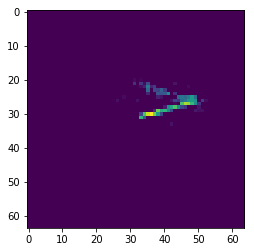

In [22]:
imshow(autoencoder.predict(example_data)[0,:,:,0])

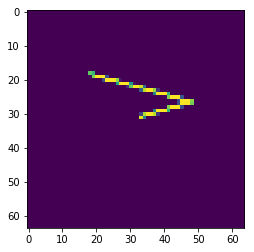

In [23]:
imshow(example_data[0][0,:,:,1])

### Alternative convolutional model

In [7]:
encoder_conv = build_conv2D_encoder()
decoder_dense = build_dense_decoder()

In [8]:
optimizer = tf.keras.optimizers.Adam(1e-3)

autoencoder_conv = tf.keras.Model(encoder_conv.input, decoder_dense(encoder_conv(encoder_conv.input)), name = "autoencoder")

autoencoder_conv.compile(optimizer = 'adam', 
             loss='mse',
             metrics=['accuracy','kullback_leibler_divergence'])

In [9]:
autoencoder_conv.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 64, 64, 2)]       0         
_________________________________________________________________
encoder_model (Model)        (None, 1, 64)             992096    
_________________________________________________________________
decoder_model (Model)        (None, 64, 64, 1)         171136    
Total params: 1,163,232
Trainable params: 1,163,232
Non-trainable params: 0
_________________________________________________________________


In [25]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = autoencoder_conv.fit(train_dataset, 
                    epochs = 10, 
                    steps_per_epoch = 60)
                    #callbacks=[tensorboard_callback])

Epoch 1/10
60/60 [==============================] - 4s 59ms/step - loss: 0.0026 - accuracy: 0.9912 - kullback_leibler_divergence: 0.0399
Epoch 2/10
60/60 [==============================] - 3s 58ms/step - loss: 0.0027 - accuracy: 0.9912 - kullback_leibler_divergence: 0.0403
Epoch 3/10
60/60 [==============================] - 3s 58ms/step - loss: 0.0027 - accuracy: 0.9912 - kullback_leibler_divergence: 0.0399
Epoch 4/10
60/60 [==============================] - 3s 58ms/step - loss: 0.0026 - accuracy: 0.9912 - kullback_leibler_divergence: 0.0403
Epoch 5/10
60/60 [==============================] - 3s 58ms/step - loss: 0.0026 - accuracy: 0.9912 - kullback_leibler_divergence: 0.0400
Epoch 6/10
60/60 [==============================] - 4s 59ms/step - loss: 0.0026 - accuracy: 0.9912 - kullback_leibler_divergence: 0.0398
Epoch 7/10
60/60 [==============================] - 4s 59ms/step - loss: 0.0027 - accuracy: 0.9912 - kullback_leibler_divergence: 0.0401
Epoch 8/10
60/60 [=======================

In [26]:
example_data = next(iter(train_dataset))

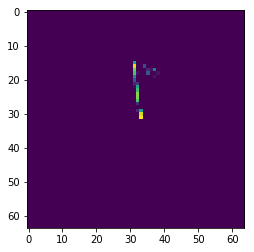

In [27]:
imshow(autoencoder_conv.predict(example_data)[0,:,:,0])

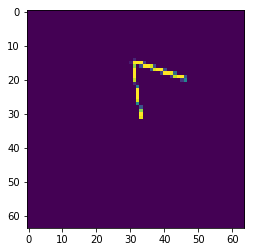

In [13]:
imshow(example_data[0][0,:,:,1])

### Visualization of ConvNet Filters

In [28]:
model = encoder_conv  
layer_name = 'conv_y_2'
input_layer = 'encoder_input'
intermediate_layer_model = tf.keras.Model(inputs=model.get_layer(input_layer).input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(example_data)


model = tf.keras.Sequential()
model.add(tf.keras.Input(shape = (64,64,1)))
model.add(intermediate_layer_model.layers[3])
model.add(intermediate_layer_model.layers[4])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_y_1 (Conv2D)            (None, 31, 31, 32)        320       
_________________________________________________________________
conv_y_2 (Conv2D)            (None, 15, 15, 64)        18496     
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


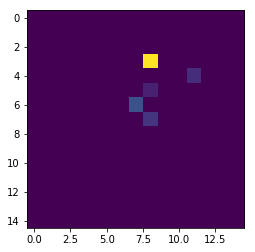

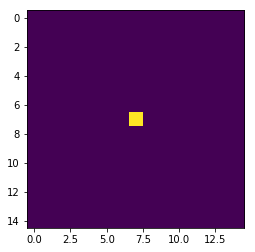

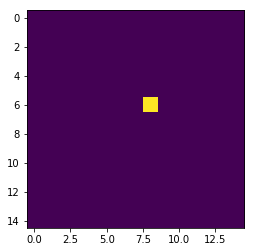

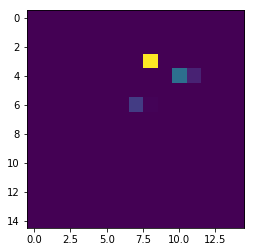

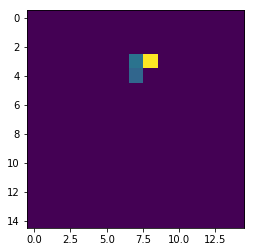

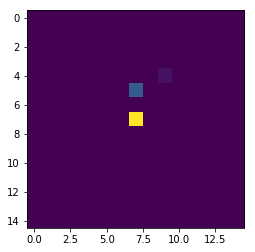

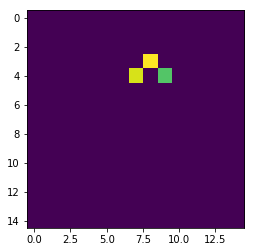

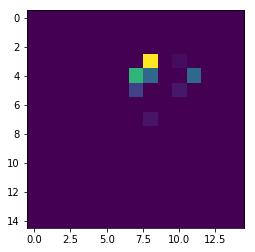

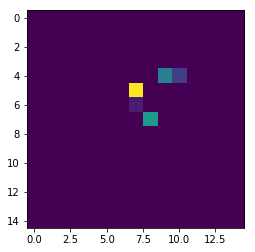

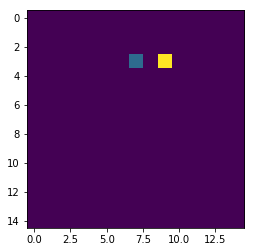

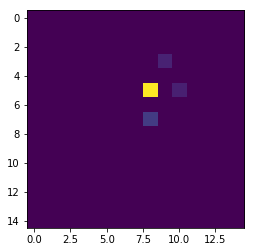

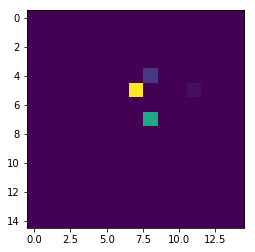

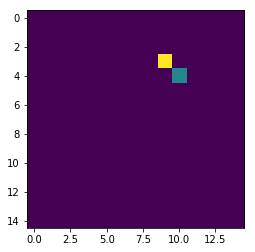

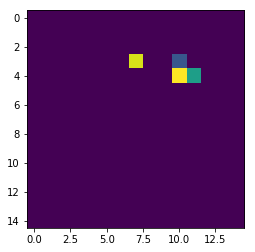

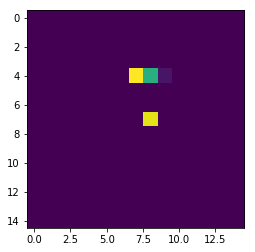

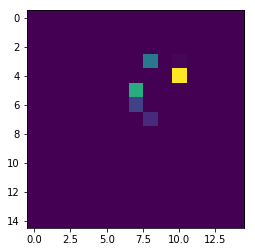

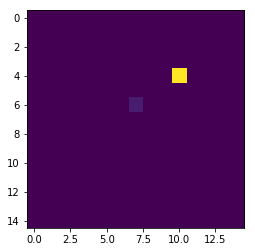

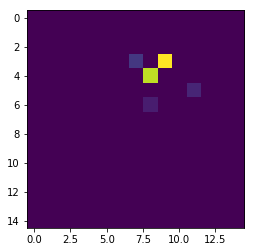

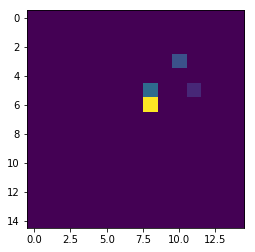

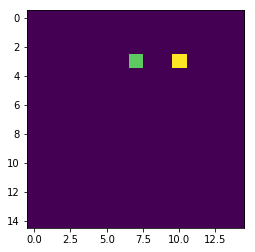

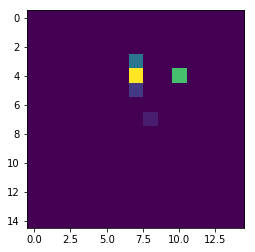

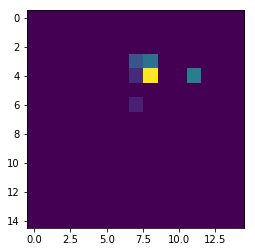

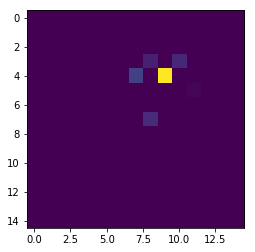

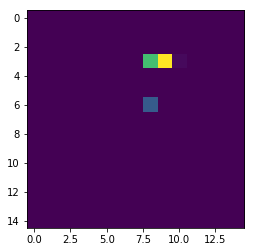

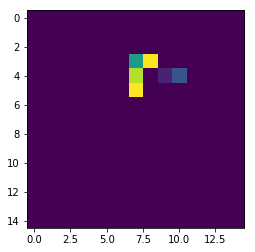

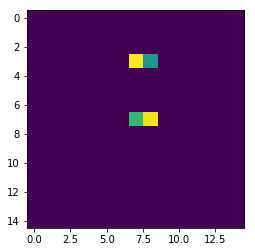

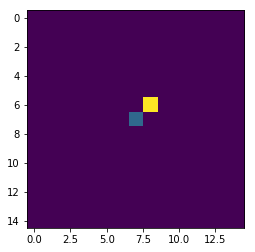

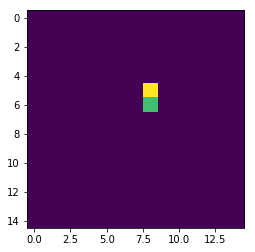

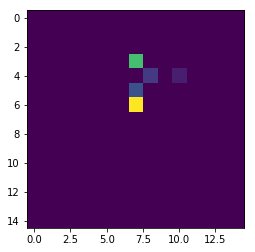

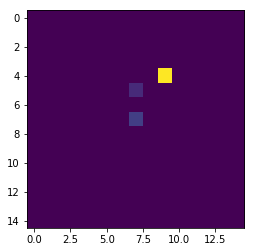

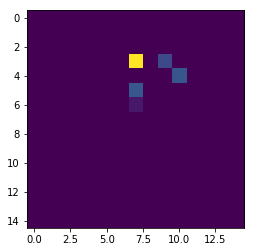

In [30]:
for i in range(31):
    plt.figure()
    plt.imshow(intermediate_output[0][:,:,i])

In [34]:
size = 64
margin = 5
results = np.zeros((8*size + 7*margin, 8*size + 7*margin, 1))

for i in tqdm.tqdm(range(8)):
    for j in tqdm.tqdm(range(8)):
        filter_img = generate_conv_pattern(model, i + (j*8), 10000)
        horizontal_start = i * size + i + margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, : ] =  filter_img

100%|██████████| 8/8 [08:13<00:00, 61.95s/it]


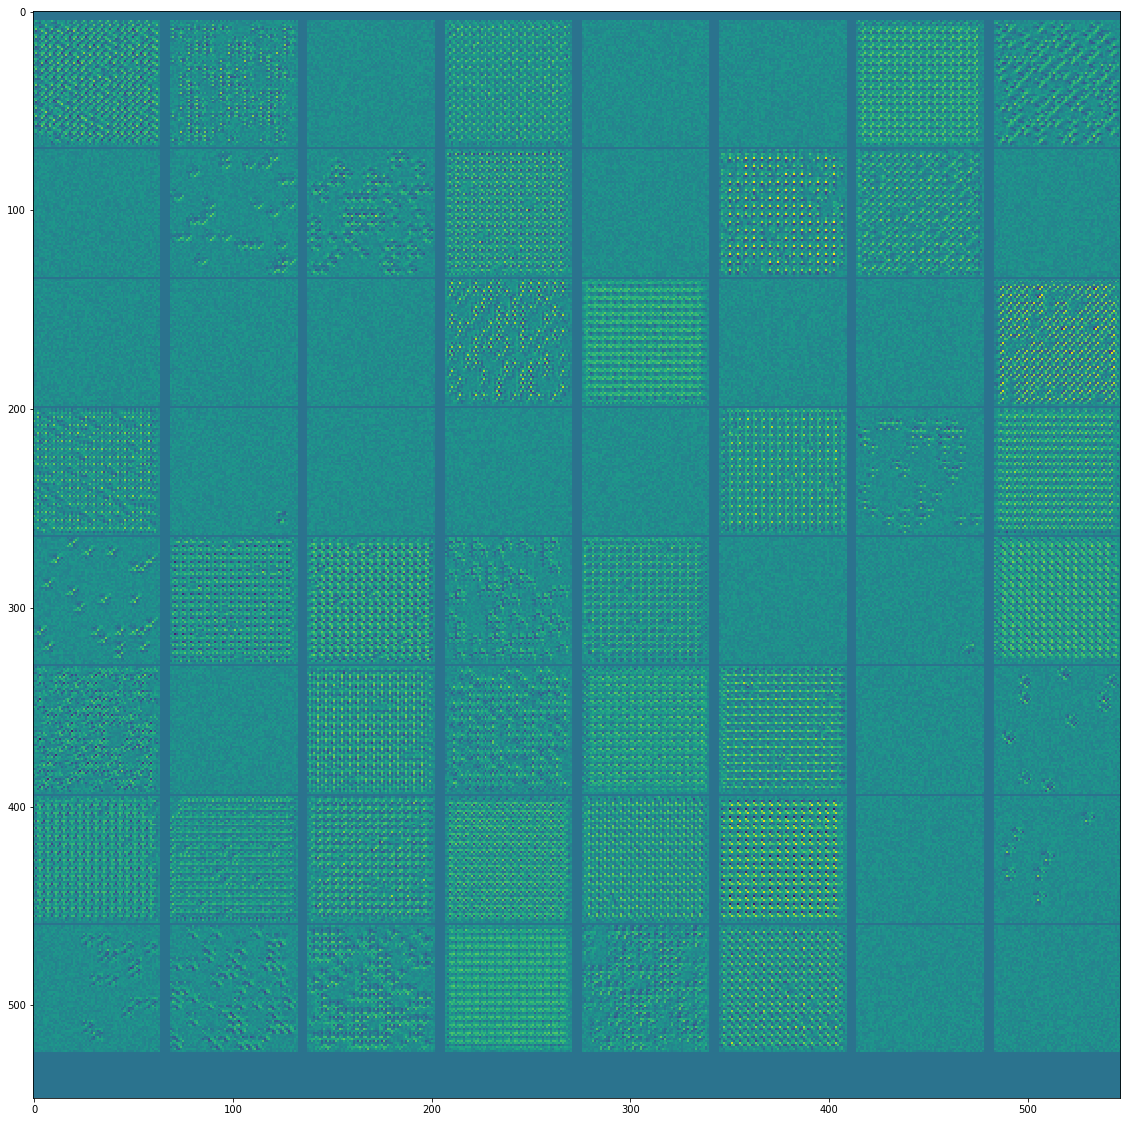

In [35]:
plt.figure(figsize=(20,20))
plt.imshow(results[:,:,0])
savefig('images/filter_conv_response.png')

### Visualization of dense layers

In [36]:
model = encoder_conv
model.output
model.input

<tf.Tensor 'encoder_input:0' shape=(None, 64, 64, 2) dtype=float32>

In [ ]:
size = 64
margin = 5
results = np.zeros((8*size + 7*margin, 8*size + 7*margin, 1))

for i in tqdm.tqdm(range(8)):
    for j in tqdm.tqdm(range(8), leave=False):
        filter_img = generate_pattern(model, i + (j*8), 10000)
        horizontal_start = i * size + i + margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, : ] =  filter_img

plt.figure(figsize=(20,20))
plt.imshow(results[:,:,0])

 62%|██████▎   | 5/8 [01:20<00:48, 16.09s/it]

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(results[:,:,0])
savefig('images/filter_response.png')